In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import librosa

## Need some catchy figures that see those people relate to `earth quake`

## Introduction

# Load & Visualize the data

In [2]:
df = pd.read_csv('test01.csv')

In [3]:
df.head()

,Unnamed: 0,acoustic_data,time_to_failure
0,100000000,8,1.2148
1,100000001,7,1.2148
2,100000002,7,1.2148
3,100000003,4,1.2148
4,100000004,3,1.2148


### Need to draw `some boxes` to show that we need to map from `time-series window` to `output`

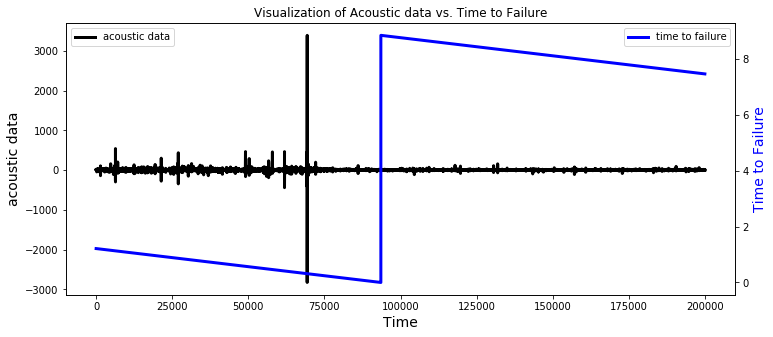

In [4]:
acoustic_data_visual = df['acoustic_data'].values[::50]
time_to_failure_visual = df['time_to_failure'].values[::50]

fig, ax1 = plt.subplots(figsize = (12,5))
plt.title('Visualization of Acoustic data vs. Time to Failure')
plt.plot(acoustic_data_visual, color = 'black', linewidth = 3, label = 'acoustic data')
ax1.set_ylabel('acoustic data', fontsize = 14, color = 'black'); ax1.set_xlabel('Time',fontsize = 14)

ax2 = ax1.twinx()
plt.plot(time_to_failure_visual, color = 'blue', linewidth = 3,label = 'time to failure')
ax2.set_ylabel('Time to Failure', color = 'blue', fontsize = 14); 
ax1.legend(loc=2);ax2.legend(loc=1)

del acoustic_data_visual
del time_to_failure_visual

# Need to draw some boxes to show that we need to map from time-series window to time

# Feature Engineering

In [5]:
def generate_feature_basic(seg_id, seg, X):
    xc = pd.Series(seg['acoustic_data'].values)
    
    X.loc[seg_id, 'index'] = seg_id
    X.loc[seg_id, 'mean'] = xc.mean()
    X.loc[seg_id,'std'] = xc.std()
    #X.loc[seg_id, 'kurt'] = xc.kurtosis()
    X.loc[seg_id, 'skew'] = xc.skew()

In [6]:
def generate_feature_FFT(seg_id, seg, X):
    xc = pd.Series(seg['acoustic_data'].values)
    zc = np.fft.fft(xc)
    realFFT, imagFFT = np.real(zc), np.imag(zc)
    
    X.loc[seg_id, 'FFT_mean_real'] = realFFT.mean()
    X.loc[seg_id, 'FFT_mean_imag'] = imagFFT.mean()
    X.loc[seg_id, 'FFT_std_real'] = realFFT.std()
    X.loc[seg_id, 'FFT_std_max'] = realFFT.max()

In [7]:
def generate_feature_Roll(seg_id, seg, X):
    xc = pd.Series(seg['acoustic_data'].values)
    
    windows = 100
    x_roll_std = xc.rolling(windows).std().dropna().values
    x_roll_mean = xc.rolling(windows).mean().dropna().values
    
    X.loc[seg_id, 'Roll_std_p05'] = np.percentile(x_roll_std, 5)
    X.loc[seg_id, 'Roll_std_p30'] = np.percentile(x_roll_std,30)
    X.loc[seg_id, 'Roll_std_p60'] = np.percentile(x_roll_std,60)
    X.loc[seg_id, 'Roll_std_absDiff'] = np.mean(np.diff(x_roll_std))
    
    X.loc[seg_id, 'Roll_mean_p05'] = np.percentile(x_roll_mean, 5)
    X.loc[seg_id, 'Roll_mean_absDiff'] = np.mean(np.diff(x_roll_mean))

In [8]:
def generate_feature_Melfrequency(seg_id, seg, X):
    xc = seg['acoustic_data'].values
    mfcc = librosa.feature.mfcc(xc.astype(np.float64))
    mfcc_mean = mfcc.mean(axis = 1)
    
    X.loc[seg_id, 'MFCC_mean02'] = mfcc_mean[2]
    X.loc[seg_id, 'MFCC_mean16'] = mfcc_mean[16]

# Load the full train data

In [9]:
chunksize = 150000
CsvFileReader = pd.read_csv('train.csv', chunksize = chunksize)

In [10]:
X, y = pd.DataFrame(), pd.DataFrame()

for seg_id, seg in tqdm_notebook(enumerate(CsvFileReader)):
    y.loc[seg_id, 'target'] = seg['time_to_failure'].values[-1]
    generate_feature_basic(seg_id, seg, X)
    generate_feature_FFT(seg_id, seg, X)
    generate_feature_Roll(seg_id, seg, X)
    generate_feature_Melfrequency(seg_id, seg, X)

X.to_csv('extract_train_Jul08.csv')
y.to_csv('extract_label_Jul08.csv')

# Visualize the features

In [11]:
X1, y1 = X.iloc[500:1000], y.iloc[500:1000]

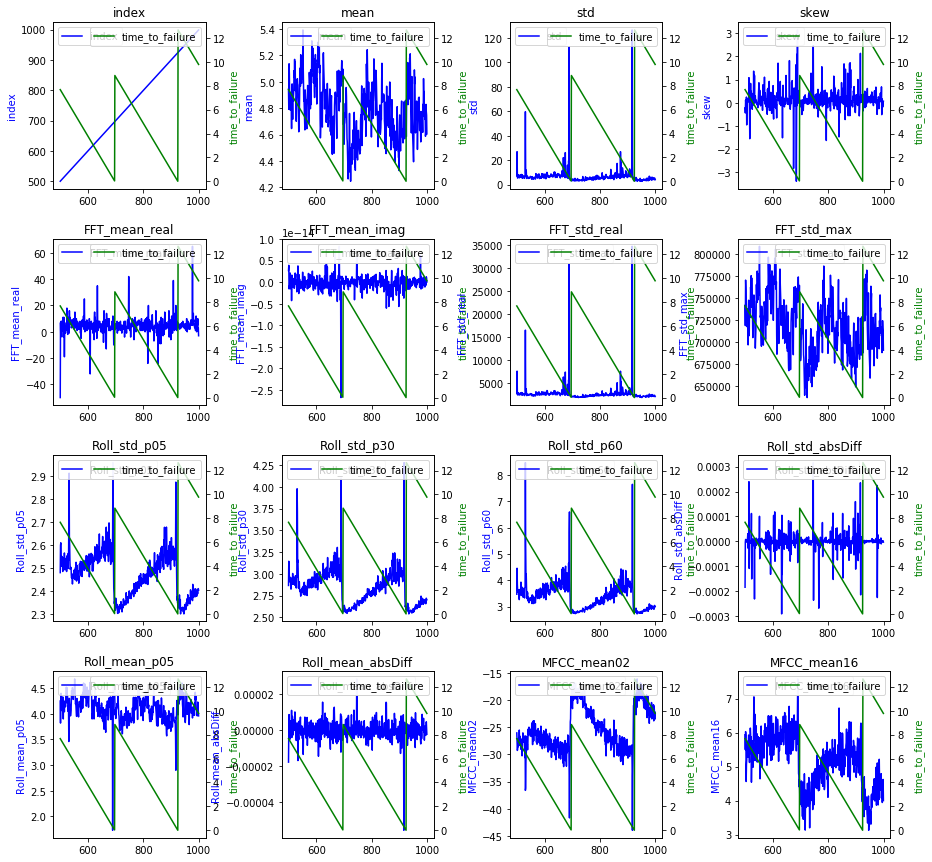

In [12]:
plt.figure(figsize=(15, 15))
for i, col in enumerate(X.columns):
    ax1 = plt.subplot(4, 4, i + 1)
    plt.plot(X1[col], color='blue');plt.title(col);ax1.set_ylabel(col, color='b')
    ax2 = ax1.twinx(); plt.plot(y1, color='g'); ax2.set_ylabel('time_to_failure', color='g')
    ax1.legend(loc= 2);ax2.legend(['time_to_failure'], loc=1)
plt.subplots_adjust(wspace=0.5, hspace=0.3)

# Load the test data and visualize

In [13]:
submission = pd.read_csv('sample_submission.csv', index_col='seg_id')

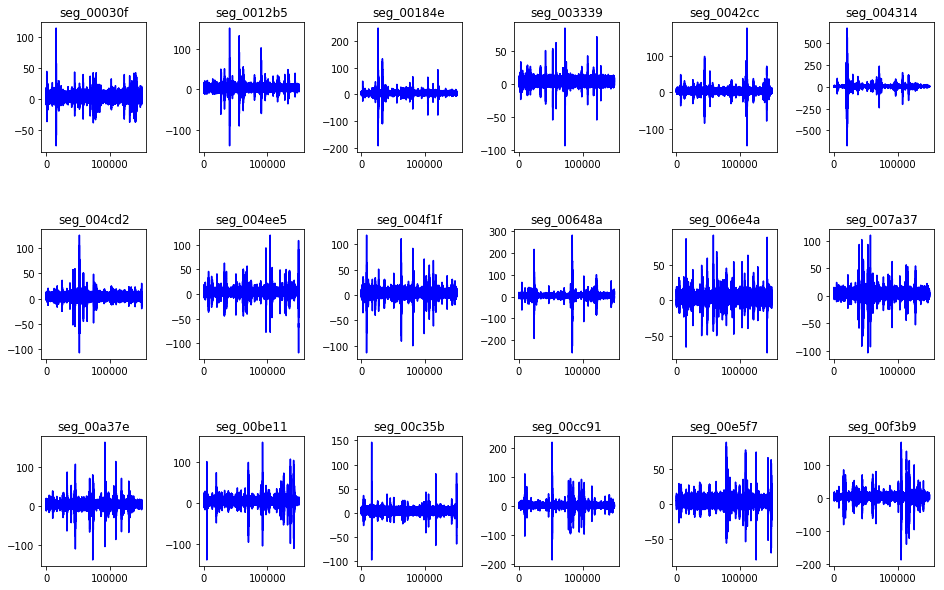

In [14]:
X_test = pd.DataFrame()
plt.figure(figsize=(16,10))
plt.subplots_adjust(wspace=0.5, hspace=0.6)
for ii,seg_name in tqdm_notebook(enumerate(submission.index)):
    seg = pd.read_csv('test/{}.csv'.format(seg_name))
    generate_feature_basic(seg_name, seg, X_test)
    generate_feature_FFT(seg_name, seg,  X_test)
    generate_feature_Roll(seg_name, seg,  X_test)
    generate_feature_Melfrequency(seg_name, seg,  X_test)
    
    if ii<18:
        ax1 = plt.subplot(3, 6, ii + 1)
        plt.plot(seg['acoustic_data'].values, color='blue')
        plt.title(seg_name)
X.to_csv('extract_test_Jul08.csv')